# <font color='orange'>Course on ADAPTIVE COLLECTIVE SYSTEMS</font>
# <font color='orange'>1. Axelrod's model of collective dissemination</font>

# <font color="green">Cogmaster SUP, 2023-2024</font>

*Teacher: nicolas.bredeche(at)sorbonne-universite.fr*

*Last update: 24/9/2024*


This notebook can be executed in [Google Colab](colab.research.google.com/) or in Jupyter Lab.


# PLEASE FILL IN THE FOLLOWING BEFORE YOU START:

* Student 1: **_Name_ _Firstname_ _StudentCardNumber_**
* Student 2: **_Name_ _Firstname_ _StudentCardNumber_**

This first practical course will not be evaluated. Parts 1 and 2 are mandatory to understand the basic concepts of sociophysics models. Other parts are important but not critical. Part 4 can be more or less difficult to implement depending on how much the code is optimized.



---
---
---

# <font color='orange'>PREAMBULE: initialization</font>

# Axelrod Model simulator

This cell contains all the necessary functions to run Axelrod's model for cultural dissemination.

**<font color='red'>Important remark</font>**: *This cell **must** be executed before anything else. Unless you modify its content, it is not required to execute it more than once in a session.*

**Technical hint**: *The most important function is update_traits(-), where the mode of interaction between individuals is defined. It is not necessary to study this cell for the moment.*

In [1]:
from IPython.core import getipython
import sys
import subprocess
execute_in_notebook = False

if 'google.colab' in str(getipython.get_ipython()):
    execute_in_notebook = True
print("Running in",str(getipython.get_ipython()))

try:
    import google.colab
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'numba'])
except ImportError:
    # Not in Google Colab, continue execution normally
    pass

# Import Libraries
import time
from datetime import datetime
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from numba import njit
from IPython.display import HTML
from matplotlib import rc
import matplotlib as mpl

display_info = True # all other messages
display_full_stats = False # display stats of number of cultures

track_cultures_over_time = True # for every frames, store (#iterations,#cultures) in cultures_over_time
cultures_over_time = [] # Array with structure: (#iterations,#cultures)^N_frames

def set_debug(_display_info = display_info, _display_full_stats = display_full_stats, _track_cultures_over_time = track_cultures_over_time):
    global display_info,display_full_stats,track_cultures_over_time
    display_full_stats = _display_full_stats
    display_info = _display_info
    track_cultures_over_time = _track_cultures_over_time

# Set up Matplotlib to display animations in the notebook
mpl.rcParams['animation.embed_limit'] = 100  # Set the limit to 100 MB or another larger value
rc('animation', html='jshtml')

# Parameters -- DEFAULT VALUES

L = 30  # Squared lattice size
F = 3   # Number of features / traits per agent
Q = -1  # Number of trait values per feature (should be >0)

num_iterations = 20000000 # 20000000 # control parameter -- rule of thumb: > L×L×10. But should be large enough to observe stabilization.
num_frames_displayed = 100 # can be set up by hand (default: 100)
num_iterations_between_frames = int(num_iterations / num_frames_displayed) # number of interaction steps per frame
iterations = 0
im = ax = traits = None

# Precompute neighbor shifts for periodic boundary conditions
neighbor_shifts = np.array([(-1, 0), (1, 0), (0, -1), (0, 1)]) # Von Neumann

@njit
def update_traits(traits, L, F, N_steps, neighbor_shifts):
    for _ in range(N_steps):
        # Select a random agent
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)
        # Select a random neighbor direction
        shift = neighbor_shifts[np.random.randint(0, 4)]
        ni = (i + shift[0]) % L
        nj = (j + shift[1]) % L

        # Compute similarity
        distance = np.mean(np.where(traits[i,j]==traits[ni,nj],0,1))
        similarity = 1.0 - distance

        # With probability S, agents interact
        if np.random.rand() < similarity:
            # Select a random trait to adjust
            k = np.random.randint(0, F)
            # Agent i,j adopts the trait from neighbor ni,nj
            traits[i, j, k] = traits[ni, nj, k]
    return traits

def update(frame):
    global traits,iterations,num_iterations_between_frames,im,ax,display_info

    if display_info == True and iterations == 0:
        print ("__________")

    if iterations < num_iterations:
        traits = update_traits(traits, L, F, num_iterations_between_frames, neighbor_shifts)
        iterations = iterations + num_iterations_between_frames
        if display_info == True and iterations%(num_iterations/10) == 0:
            #print (iterations,"/",num_iterations)
            #print (f"{int(iterations/num_iterations*100)}%")
            print (".", end="", flush=True)
            if iterations == num_iterations:
                print()
        if track_cultures_over_time == True:
            cultures_over_time.append([iterations,get_stats()[0]])

    # Update the image data
    im.set_data(traits)
    #ax.set_title(f"Iteration: {frame * N_steps}")
    ax.set_title(f"Q={Q},F={F},arena={L}x{L}\nIterations: {int(iterations)} / {num_iterations} ({int(iterations/num_iterations*100)}%)")
    return [im]

def get_stats():
    global traits

    arr_2d = traits.reshape(-1, 3)
    arr_rounded = np.round(arr_2d, decimals=8)  # Round to reduce floating-point errors
    unique_vectors, counts = np.unique(arr_rounded, axis=0, return_counts=True)
    num_unique_vectors = unique_vectors.shape[0]
    sorted_indices = np.argsort(-counts)
    sorted_vectors = unique_vectors[sorted_indices]
    sorted_counts = counts[sorted_indices]

    return num_unique_vectors,sorted_vectors,sorted_counts

def display_plot(data):
    global L

    data = np.array(data)
    x = data[:, 0]
    y = data[:, 1]
    plt.figure(figsize=(6, 4))
    plt.plot(x, y, marker='o', linestyle='-', color='b', label='Data')
    plt.xlabel('iterations')
    plt.ylabel('#cultures')
    plt.title(f"Q={Q},F={F},arena={L}x{L}\ncultural dissemination over time")
    #plt.legend()
    plt.ylim(0, min(L*L,Q**F))
    plt.grid(True)
    plt.show()

def run(_Q, _F = F, _L = L, _num_iterations = num_iterations, _num_frames_displayed = num_frames_displayed):
    global L,F,Q,num_iterations,num_frames_displayed,traits,im,ax,iterations,display_info,display_stats,display_graphics,cultures_over_time,num_iterations_between_frames

    start_time = time.time()

    Q = _Q
    F = _F
    L = _L
    num_iterations = _num_iterations
    num_frames_displayed = _num_frames_displayed
    num_iterations_between_frames = int(num_iterations / num_frames_displayed) # must be updated
    iterations = 0

    im = ax = traits = None

    cultures_over_time = []

    # Generate Q distinct real values between 0 and 1
    values = np.linspace(0, 1, Q, endpoint=False) + (0.5 / Q)  # Shift to avoid including 0
    traits = np.random.choice(values, size=(L, L, F))
    #print (traits)

    # Set up the plot
    fig, ax = plt.subplots()
    im = ax.imshow(traits, interpolation='nearest', animated=True)
    ax.axis('off')

    # Display information
    if display_info == True:
        print ("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")
        print ("Arena                  :",L,"x",L)
        print ("Number of features     :",F)
        print ("Number of trait values :",Q)
        print ("Iterations             :",num_iterations)
        print ("Display",num_frames_displayed,"frames (ie. every",num_iterations_between_frames,"iterations)")

    # Create the animation
    if track_cultures_over_time == True:
        cultures_over_time.append([iterations,get_stats()[0]])

    ani = FuncAnimation(fig, update, frames=num_frames_displayed-1, blit=True, repeat=False, interval=1)

    # Display the animation
    if execute_in_notebook == False:
        plt.show() # from terminal
    else:
        display(HTML(ani.to_jshtml())) # from a Google Colab notebook

    final_num_unique_vectors,final_sorted_vectors,final_sorted_counts = get_stats()

    if display_info == True:
        print("Number of unique cultures:", final_num_unique_vectors)
    if display_full_stats == True:
        print("List of cultures (with surface):")
        for vector, count in zip(final_sorted_vectors, final_sorted_counts):
            print("Vector:", vector, "Count:", count)

    if track_cultures_over_time == True:
        display_plot(cultures_over_time)

    end_time = time.time()
    elapsed_time = end_time - start_time
    if display_info == True:
        print(f"{elapsed_time:.1f} sec.")

    return (final_num_unique_vectors, final_sorted_vectors, final_sorted_counts, cultures_over_time)



#### #### ####

print("\n",date.today(), datetime.now().strftime("%H:%M:%S"),"GMT") # timestamp is greenwich time
print("OK.")


Running in <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f3965c84b80>

 2024-09-24 17:34:05 GMT
OK.


---
---
---

# <font color='orange'>PART 1: simulating cultural dissemination</font>

- run the two cells below, make sure you understand the set_debug and run functions, as used below.
- analyse the outcome of the two simulations. What do you conclude?

**Methodological hint**: *Simulation is stochastic. Run multiple simulations with the same set of parameters to obtain reliable results.*

**Technical hint**: *Simulation takes time. Be careful when setting arena size, and number of frames to be rendered.*

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 20 x 20
Number of features     : 3
Number of trait values : 5
Iterations             : 5000000
Display 100 frames (ie. every 50000 iterations)
__________


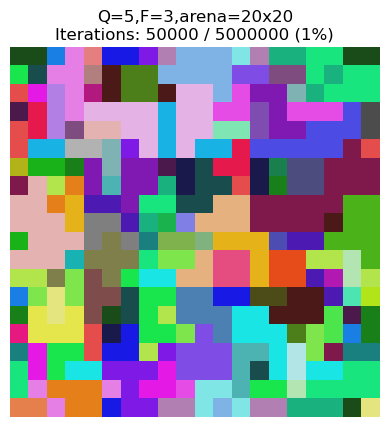

Number of unique cultures: 75
List of cultures (with surface):
Vector: [0.1 0.9 0.5] Count: 19
Vector: [0.5 0.1 0.3] Count: 18
Vector: [0.9 0.7 0.9] Count: 14
Vector: [0.9 0.7 0.7] Count: 14
Vector: [0.1 0.9 0.9] Count: 13
Vector: [0.5 0.1 0.7] Count: 12
Vector: [0.1 0.9 0.3] Count: 12
Vector: [0.3 0.1 0.1] Count: 9
Vector: [0.5 0.7 0.9] Count: 9
Vector: [0.3 0.3 0.9] Count: 9
Vector: [0.5 0.1 0.9] Count: 9
Vector: [0.5 0.3 0.9] Count: 9
Vector: [0.1 0.7 0.5] Count: 9
Vector: [0.1 0.3 0.3] Count: 9
Vector: [0.9 0.5 0.9] Count: 8
Vector: [0.1 0.1 0.9] Count: 8
Vector: [0.7 0.9 0.3] Count: 8
Vector: [0.9 0.7 0.5] Count: 8
Vector: [0.5 0.9 0.3] Count: 8
Vector: [0.3 0.7 0.1] Count: 8
Vector: [0.1 0.7 0.9] Count: 7
Vector: [0.9 0.5 0.1] Count: 7
Vector: [0.9 0.7 0.1] Count: 7
Vector: [0.9 0.3 0.3] Count: 7
Vector: [0.3 0.1 0.7] Count: 7
Vector: [0.9 0.3 0.9] Count: 7
Vector: [0.1 0.3 0.1] Count: 6
Vector: [0.7 0.5 0.7] Count: 6
Vector: [0.9 0.1 0.9] Count: 6
Vector: [0.3 0.5 0.7] Count: 6


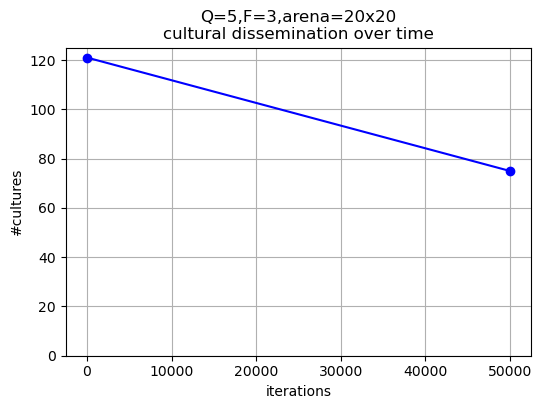

0.9 sec.


In [2]:
set_debug(_display_info=True,
          _display_full_stats=True,
          _track_cultures_over_time=True)
retValues = run( _Q=5, _F=3, _L=20, _num_iterations = 5000000, _num_frames_displayed = 100 )

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 20 x 20
Number of features     : 3
Number of trait values : 18
Iterations             : 5000000
Display 100 frames (ie. every 50000 iterations)
__________


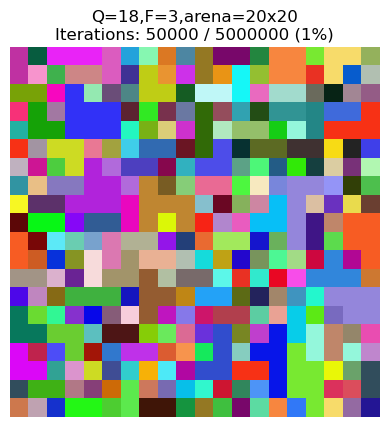

Number of unique cultures: 260


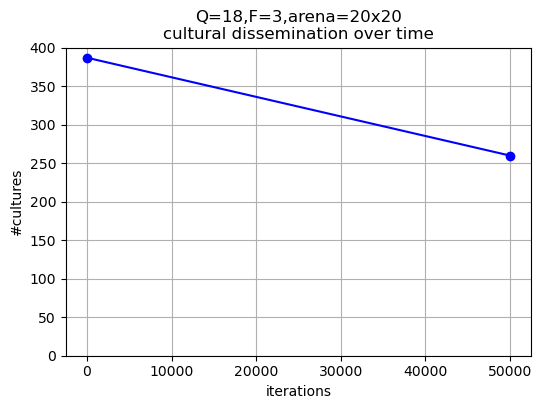

0.1 sec.


In [3]:
set_debug(_display_info=True,
          _display_full_stats=False,
          _track_cultures_over_time=True)
retValues = run( _Q=18, _F=3, _L=20, _num_iterations = 5000000, _num_frames_displayed = 100 )

<font color='green'>Your comments:</green>

Sur les deux expériences, on observe dans le premier cas une population avec une petite variété de "traits" (de phénotype), il y a 3 caractère et 5 caractéristique possible pour chacun donc 3**5 phénotype possible.
Cependant, on compare la similarité caractère par caractère avec un voisin. Plus cette similiarité est grande, plus il y a de chance de "copier" les caractère du voisin (tout en gardant un caractère inchangé, tiré au hasard).
Dans ce cas, il y a chance assez importante qu'un individu partage une assez grande similarité avec un voisin, on remarque donc que la population générale va converger vers un phénotype (qui varie en fonction des itérations).


Dans le cas de la deuxième, le nombre de "traits" pour chaque caractéristique est plus grand, ce qui rend le score de similarité plus bas en général, diminuant les probabilités de copie de caractéritistique.
On n'observe pas de convergence vers 1 phénotype précis, cependant on peut observer des zones convergeant de manière local vers un phénotype.

---
---
---

# <font color='orange'>PART 2: revealing a phase transition</font>

- Find whether there  is a phase transition w.r.t. the number of traits (Q). Show a figure with the number of cultures (Y-axis) obtained with different Q values (X-axis) after stabilization.

**Methodological hint**: *The phase transition may not be sharp. Consider a careful exploration of Q values around the phase transition, and larger steps outside.*

**Technical hint**: *You can use either plot function defined in the first cell (copy and modify it) or an external tool (e.g. Libroffice, google spreadsheet)*

**Technical hint**: *the run(-) function returns some statistics in a structure array. The first component of the array (e.g. retValues[0]) contains the number of cultures at the end of a simulation*

**Technical hint**: *you can call several run(-) functions in sequence within the same cell.*

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 20 x 20
Number of features     : 3
Number of trait values : 5
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

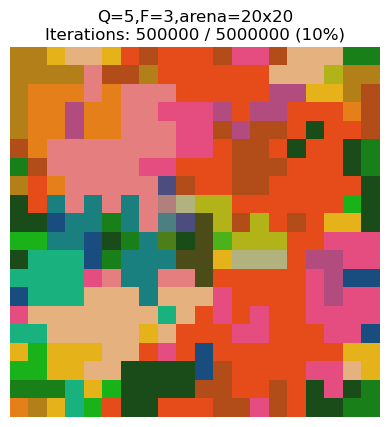

Number of unique cultures: 23
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 20 x 20
Number of features     : 3
Number of trait values : 6
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

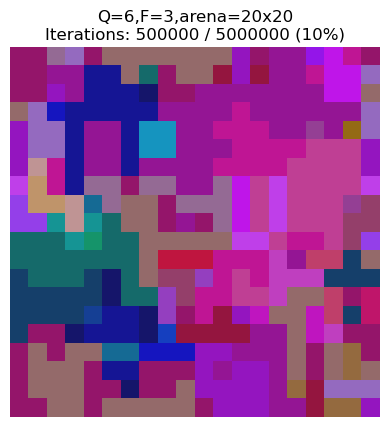

Number of unique cultures: 36
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 20 x 20
Number of features     : 3
Number of trait values : 7
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

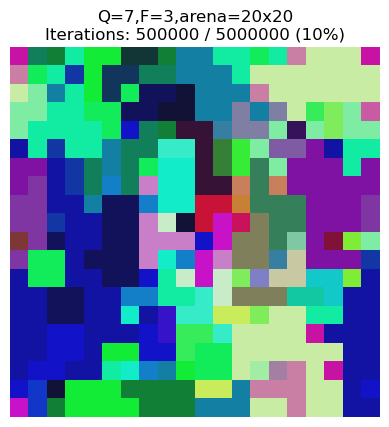

Number of unique cultures: 54
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 20 x 20
Number of features     : 3
Number of trait values : 8
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

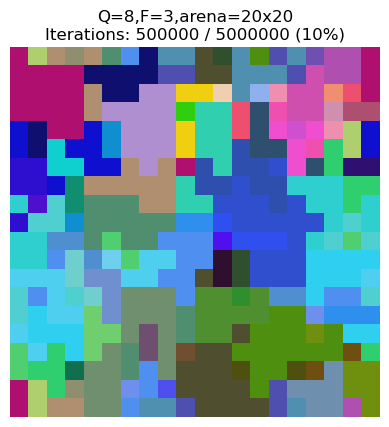

Number of unique cultures: 66
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 20 x 20
Number of features     : 3
Number of trait values : 9
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

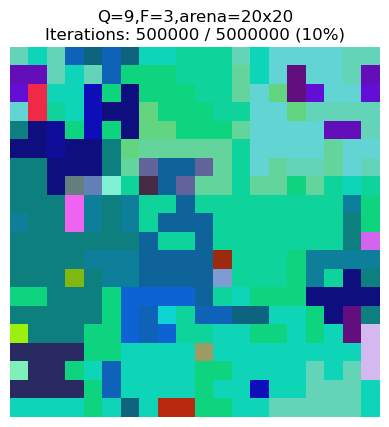

Number of unique cultures: 37
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 20 x 20
Number of features     : 3
Number of trait values : 10
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

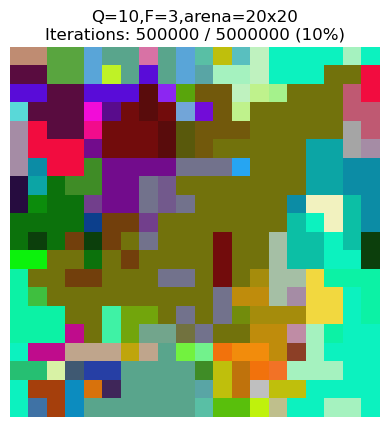

Number of unique cultures: 86
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 20 x 20
Number of features     : 3
Number of trait values : 11
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

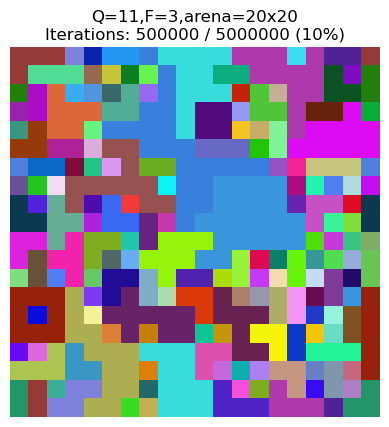

Number of unique cultures: 157
0.2 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 20 x 20
Number of features     : 3
Number of trait values : 12
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

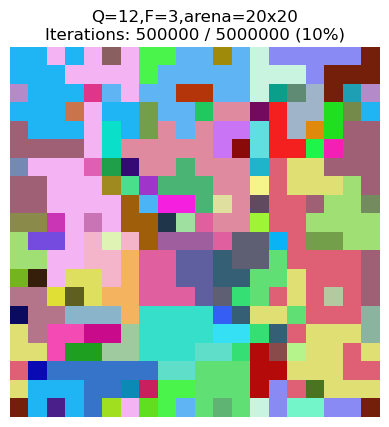

Number of unique cultures: 100
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 20 x 20
Number of features     : 3
Number of trait values : 13
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

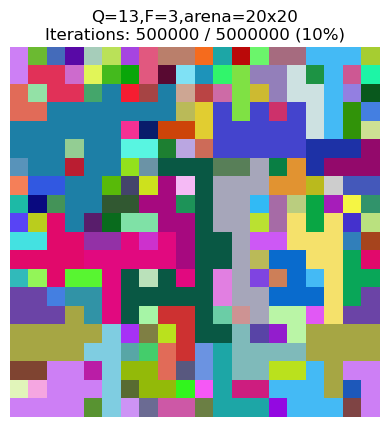

Number of unique cultures: 154
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 20 x 20
Number of features     : 3
Number of trait values : 14
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

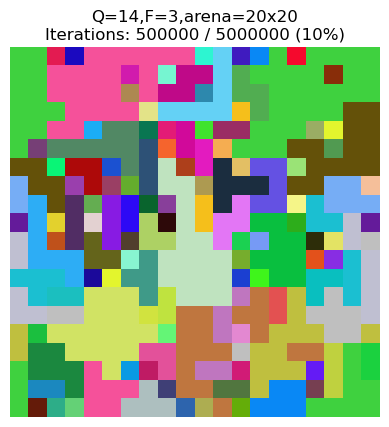

Number of unique cultures: 114
0.1 sec.


In [4]:
set_debug(_display_info=True,
          _display_full_stats=False,
          _track_cultures_over_time=False)
lNbCultur = []
for nb_traits in range(5, 15):
  nb_diff_culture = 0
  retValues = run( _Q=nb_traits, _F=3, _L=20, _num_iterations = 5000000, _num_frames_displayed = 10 )
  for i in range(4):
    nb_diff_culture += retValues[0]
  nb_diff_culture /= 4
  lNbCultur.append((nb_traits,nb_diff_culture))

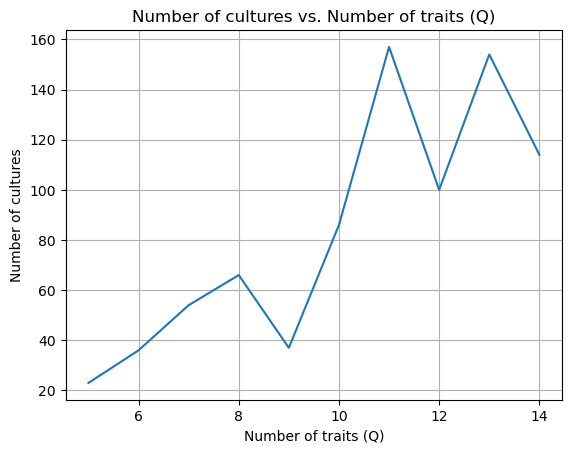

In [5]:
# prompt: Plot the list LNbCultur

import matplotlib.pyplot as plt

x_values = [item[0] for item in lNbCultur]
y_values = [item[1] for item in lNbCultur]

plt.plot(x_values, y_values)
plt.xlabel("Number of traits (Q)")
plt.ylabel("Number of cultures")
plt.title("Number of cultures vs. Number of traits (Q)")
plt.grid(True)
plt.show()


<font color='green'>Your comments:</green>

On remarque que le nombre de culture augmente à partir de 8 traits, à partir de ce paramètre, la population ne peut plus converger.

---
---
---

# <font color='orange'>PART 3: Parameter sensitivity and model implementation</font>

- Reveal the phase transition (using Q) with a larger arena (try with 30x30). Revert to 20x20 after this question.
- Reveal the phase transition (using Q) with a *Moore* neighborhood (ie. 8 neighbours). Revert to the original *Von Neumann* neighborhood (ie. 4 neighbours) after this question.

**Methodological hint**: *take a look at update_traits(-) in the first cell (relevant for question 2).*





=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 30 x 30
Number of features     : 3
Number of trait values : 5
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

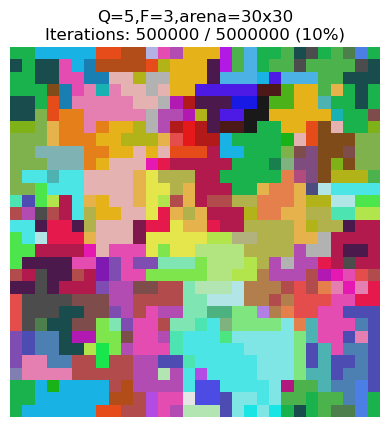

Number of unique cultures: 80
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 30 x 30
Number of features     : 3
Number of trait values : 6
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

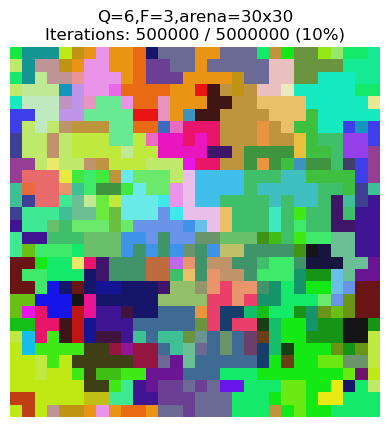

Number of unique cultures: 120
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 30 x 30
Number of features     : 3
Number of trait values : 7
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

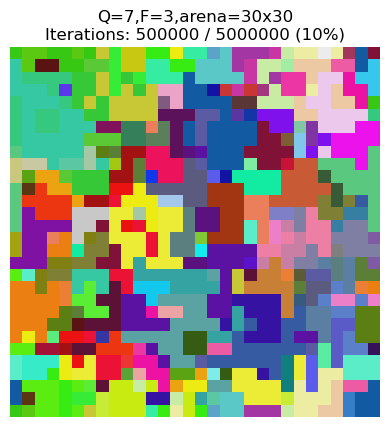

Number of unique cultures: 129
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 30 x 30
Number of features     : 3
Number of trait values : 8
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

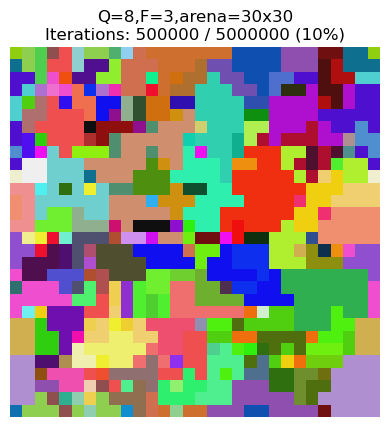

Number of unique cultures: 153
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 30 x 30
Number of features     : 3
Number of trait values : 9
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

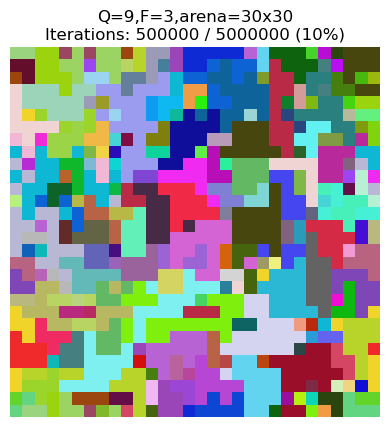

Number of unique cultures: 169
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 30 x 30
Number of features     : 3
Number of trait values : 10
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

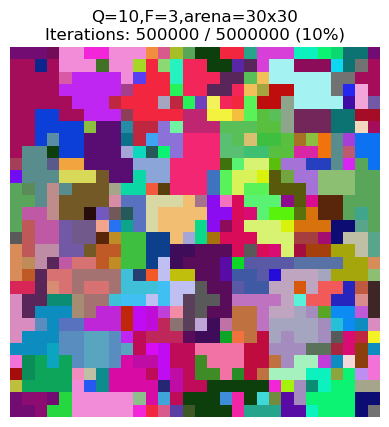

Number of unique cultures: 237
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 30 x 30
Number of features     : 3
Number of trait values : 11
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

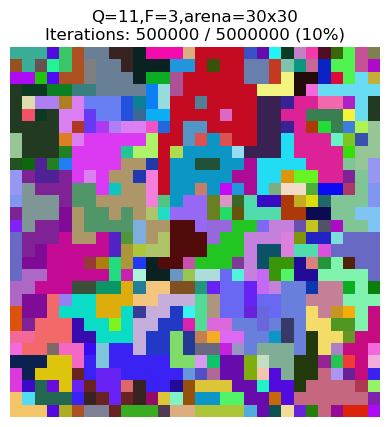

Number of unique cultures: 275
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 30 x 30
Number of features     : 3
Number of trait values : 12
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

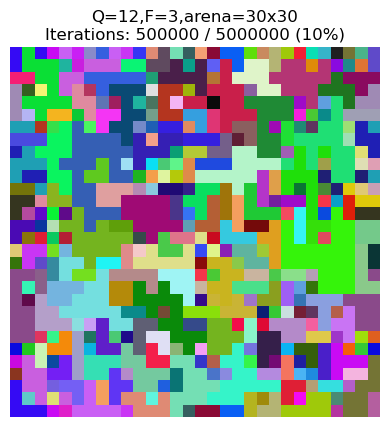

Number of unique cultures: 290
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 30 x 30
Number of features     : 3
Number of trait values : 13
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

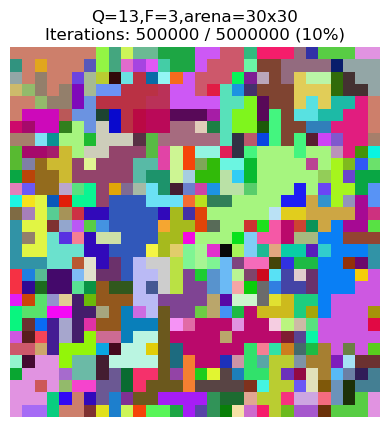

Number of unique cultures: 347
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 30 x 30
Number of features     : 3
Number of trait values : 14
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

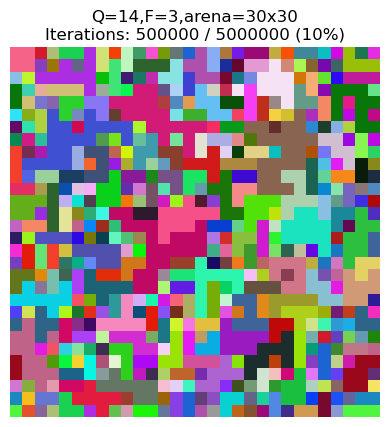

Number of unique cultures: 405
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 30 x 30
Number of features     : 3
Number of trait values : 15
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

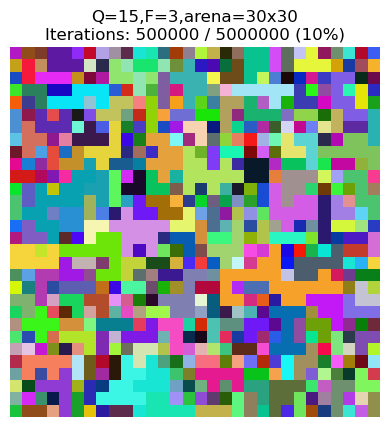

Number of unique cultures: 456
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 30 x 30
Number of features     : 3
Number of trait values : 16
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

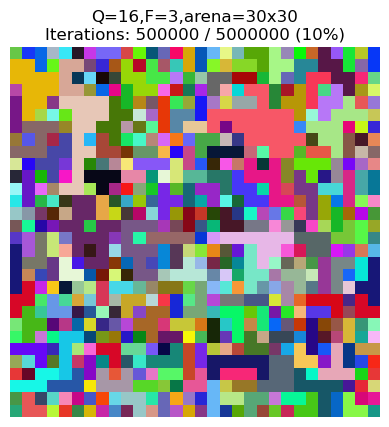

Number of unique cultures: 489
0.1 sec.
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Arena                  : 30 x 30
Number of features     : 3
Number of trait values : 17
Iterations             : 5000000
Display 10 frames (ie. every 500000 iterations)
__________
.

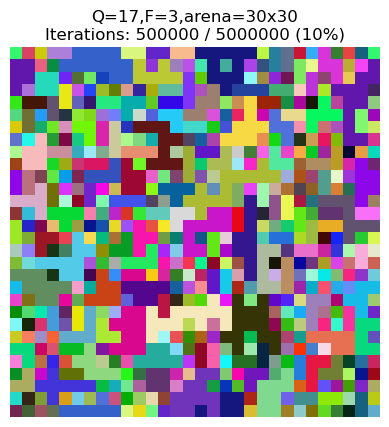

Number of unique cultures: 482
0.1 sec.


In [6]:
set_debug(_display_info=True,
          _display_full_stats=False,
          _track_cultures_over_time=False)
lNbCultur30 = []
for nb_traits in range(5, 18):
  nb_diff_culture = 0
  retValues = run( _Q=nb_traits, _F=3, _L=30, _num_iterations = 5000000, _num_frames_displayed = 10 )
  for i in range(4):
    nb_diff_culture += retValues[0]
  nb_diff_culture /= 4
  lNbCultur30.append((nb_traits,nb_diff_culture))

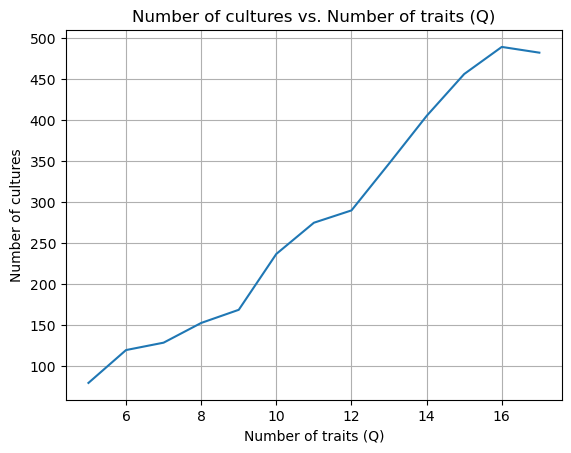

In [7]:
# prompt: Plot the list LNbCultur30

import matplotlib.pyplot as plt

x_values = [item[0] for item in lNbCultur30]
y_values = [item[1] for item in lNbCultur30]

plt.plot(x_values, y_values)
plt.xlabel("Number of traits (Q)")
plt.ylabel("Number of cultures")
plt.title("Number of cultures vs. Number of traits (Q)")
plt.grid(True)
plt.show()


<font color='green'>Your comments:</green>

(...)

---
---
---

# <font color='orange'>PART 4: Topological considerations</font>

The current arena is periodic (ie. a torus, not a sheet). We will now study what happens when the topology is different.

- Set up an arena with walls on the borders. The idea is to experiment with an aperiodic 2D space. Compare with original setting.
- Set up an arena in which living individuals form a ring (ie. individuals have only two neighbours). Compare with original setting.
- Set up an arena in which living individuals form two highly interconnected groups (e.g. two squared lattices), which are connected by a single individual. Compare with original setting.

**methodological hint**: *when comparing the periodic vs aperiodic 2D space, consider having the same number of individuals in the arena (ie. same number of individuals in both cases)*

**technical hint**: *Copy and modify the original code so that a cell bearing traits with negative values is ignored. Such a "dead" cell will never interact (you can see it as a wall). You will have (1) to skip update for dead cells; (2) ignore them when updating another cell; (3) ignore them when counting cultures (this step may be skipped).*



In [8]:
# your code

<font color='green'>Your comments:</green>

(...)

---
---
---

# <font color='orange'>PART 5: Open questions</font>


- What happens if thermal noise is added during copy?
- What happens if thermal noise spontaneous occurs even when not copying?
- What would be the point of adding thermal noise anyway?

In [9]:
# your code, optional -- not needed to answer.

<font color='green'>Your comments:</green>

(...)